**Marfa Zakirova, B06-906a**

## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [85]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os

from torch.utils.data import DataLoader, Subset

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [86]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [98]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [99]:
def subset_inds(dataset, ratio):
  return np.random.choice(len(dataset), size = int(len(dataset) * ratio), replace = False)

In [101]:
inds_val.shape

(12000,)

In [100]:
# i need validation set for validation 

inds_val = subset_inds(fmnist_dataset_train, 0.2)
fmnist_dataset_train = Subset(fmnist_dataset_train, [i for i in range(len(fmnist_dataset_train)) if i not in inds_val])
fmnist_dataset_valid = Subset(fmnist_dataset_train, [i for i in range(len(fmnist_dataset_train)) if i in inds_val])

print(f'Train set size: {len(fmnist_dataset_train)}')
print(f'Valisation set size: {len(fmnist_dataset_valid)}')

Train set size: 48000
Valisation set size: 9619


In [102]:
train_loader = DataLoader(fmnist_dataset_train, 
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)

val_loader = DataLoader(fmnist_dataset_valid, 
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(fmnist_dataset_test,
                          batch_size=256,
                          shuffle=False,
                          num_workers=2)

In [103]:
len(fmnist_dataset_test)

10000

In [104]:
for img, label in train_loader:
    print(img.shape)
    # print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [162]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 324),
            nn.BatchNorm1d(324),
            nn.ReLU(),
            nn.Linear(324, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes)
        )
        
    def forward(self, inp):       
        return self.model(inp)
      

In [2]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

NameError: name 'TinyNeuralNetwork' is not defined

Your experiments come here:

In [120]:
# Your experiments, training and validation loops here

def train_model(model, train_loader, val_loader, loss_fn, optimizer, n_epochs):
    train_loss = []
    val_loss = []
    val_accuracy = []

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []

        model.train(True)
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model.forward(x_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()

            optimizer.step()

            ep_train_loss.append(loss.item())
        
        model.train(False)
        with torch.no_grad():
            for x_batch, y_batch in val_loader:

                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                predictions = model.forward(x_batch)
                loss = loss_fn(predictions, y_batch)
                ep_val_loss.append(loss.item())

                y_pred = predictions.argmax(axis = 1)
                ep_val_accuracy.append(np.mean((y_pred == y_batch).cpu().numpy()))
        
        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f'Epoch #{epoch+1} / {n_epochs}')
        print(f'train loss: {np.round(train_loss[-1], 5)}')
        print(f'validation loss: {np.round(val_loss[-1], 5)}')
        print(f'validation accuracy: {np.round(val_accuracy[-1], 5)}', '\n')

    return train_loss, val_loss, val_accuracy


In [154]:
def plot_train_process(train_loss, val_loss, val_accuracy):
  fig, axes = plt.subplots(1,2, figsize = (20,6))
  axes[0].set_title('Loss')
  axes[0].set_xlabel('# epochs')
  axes[0].set_ylabel('loss value')
  axes[0].plot(train_loss,label='train')
  axes[0].plot(val_loss,label='validation')
  axes[0].legend()
  axes[0].grid(which = 'major')

  axes[1].set_title('Validation accuracy')
  axes[1].plot(val_accuracy)
  axes[1].set_xlabel('# epochs')
  axes[1].set_ylabel('accuracy value')
  axes[1].grid(which = 'major')

def accuracy_test(model, test_loader):
  model.train(False)
  y_predictions = np.array([])
  y_label = np.array([])
  with torch.no_grad():
      for x_batch, y_batch in test_loader:
          x_batch = x_batch.to(device)

          predictions = model.forward(x_batch).cpu()
          y_pred = predictions.argmax(axis = 1)

          y_predictions = np.concatenate((y_predictions, y_pred.numpy()))
          y_label = np.concatenate((y_label, y_batch.cpu()))

  print(f"Accuracy on test set: {np.round(np.mean(y_label == y_predictions),5)}")

In [164]:
tiny_model = TinyNeuralNetwork()
tiny_model = tiny_model.to(device)

# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss()
optim = torch.optim.Adam(tiny_model.parameters(), lr = 3e-4)    

train_loss_tiny, val_loss_tiny, val_accuracy_tiny = train_model(tiny_model, train_loader, val_loader, loss_fn = loss_func, optimizer = optim, n_epochs = 30)

Epoch #1 / 30
train loss: 0.58178
validation loss: 0.39068
validation accuracy: 0.85696 

Epoch #2 / 30
train loss: 0.35883
validation loss: 0.3226
validation accuracy: 0.88035 

Epoch #3 / 30
train loss: 0.31685
validation loss: 0.28856
validation accuracy: 0.89487 

Epoch #4 / 30
train loss: 0.28767
validation loss: 0.30473
validation accuracy: 0.88557 

Epoch #5 / 30
train loss: 0.2636
validation loss: 0.30647
validation accuracy: 0.88112 

Epoch #6 / 30
train loss: 0.2466
validation loss: 0.21927
validation accuracy: 0.91926 

Epoch #7 / 30
train loss: 0.22772
validation loss: 0.22861
validation accuracy: 0.91368 

Epoch #8 / 30
train loss: 0.21588
validation loss: 0.20239
validation accuracy: 0.92499 

Epoch #9 / 30
train loss: 0.2015
validation loss: 0.19041
validation accuracy: 0.93095 

Epoch #10 / 30
train loss: 0.18851
validation loss: 0.17095
validation accuracy: 0.93956 

Epoch #11 / 30
train loss: 0.1755
validation loss: 0.20924
validation accuracy: 0.92129 

Epoch #12 / 3

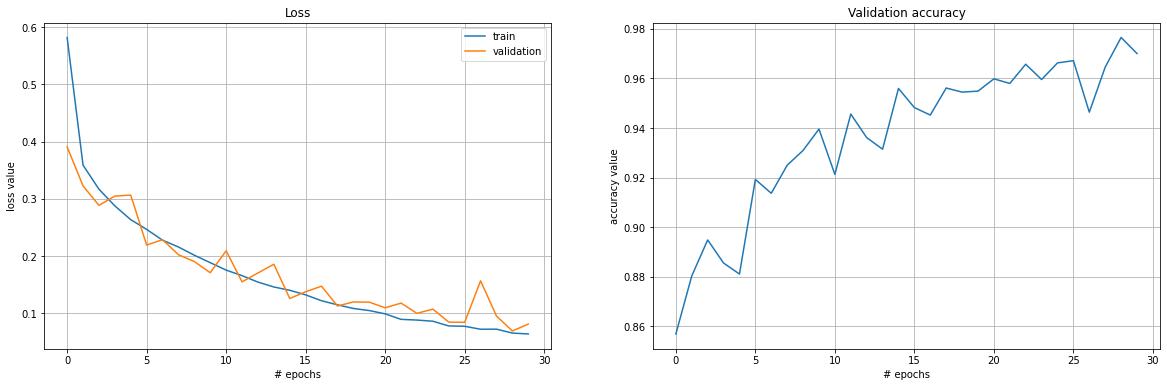

In [165]:
plot_train_process(train_loss_tiny, val_loss_tiny, val_accuracy_tiny)

In [166]:
accuracy_test(tiny_model, test_loader)

Accuracy on test set: 0.8794


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [177]:
# let's reduce the size of train dataset
inds_val_overfit = subset_inds(fmnist_dataset_train, 0.5)
fmnist_dataset_train_overfit = Subset(fmnist_dataset_train, [i for i in range(len(fmnist_dataset_train)) if i not in inds_val_overfit])
fmnist_dataset_valid_overfit = Subset(fmnist_dataset_train, [i for i in range(len(fmnist_dataset_train)) if i in inds_val_overfit])

print(f'Train set size: {len(fmnist_dataset_train_overfit)}')
print(f'Valisation set size: {len(fmnist_dataset_valid_overfit)}')

train_loader_overfit = DataLoader(fmnist_dataset_train_overfit, 
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)

val_loader_overfit = DataLoader(fmnist_dataset_valid_overfit, 
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)

test_loader_overfit = DataLoader(fmnist_dataset_test,
                          batch_size=256,
                          shuffle=False,
                          num_workers=2)

Train set size: 24000
Valisation set size: 24000


In [167]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape),
            nn.ReLU(),
            nn.Linear(input_shape, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ELU(),
            nn.Linear(500, 500),
            nn.ELU(),
            nn.Linear(500, 324),
            nn.ReLU(),
            nn.Linear(324, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [168]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 784]         615,440
              ReLU-3                  [-1, 784]               0
            Linear-4                  [-1, 500]         392,500
              ReLU-5                  [-1, 500]               0
            Linear-6                  [-1, 500]         250,500
               ELU-7                  [-1, 500]               0
            Linear-8                  [-1, 500]         250,500
               ELU-9                  [-1, 500]               0
           Linear-10                  [-1, 324]         162,324
             ReLU-11                  [-1, 324]               0
           Linear-12                  [-1, 100]          32,500
             ReLU-13                  [-1, 100]               0
           Linear-14                   

In [178]:
model_overfit = OverfittingNeuralNetwork().to(device)

oss_func = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model_overfit.parameters(), lr = 3e-4)  

# Your experiments, come here

train_loss_overfit, val_loss_overfir, val_accuracy_overfit = train_model(model_overfit, train_loader_overfit, val_loader_overfit, loss_fn = loss_func, optimizer = optim, n_epochs = 30)

Epoch #1 / 30
train loss: 0.86852
validation loss: 0.54289
validation accuracy: 0.80839 

Epoch #2 / 30
train loss: 0.517
validation loss: 0.50561
validation accuracy: 0.81753 

Epoch #3 / 30
train loss: 0.45623
validation loss: 0.44117
validation accuracy: 0.84134 

Epoch #4 / 30
train loss: 0.40064
validation loss: 0.41715
validation accuracy: 0.8487 

Epoch #5 / 30
train loss: 0.37131
validation loss: 0.3832
validation accuracy: 0.8627 

Epoch #6 / 30
train loss: 0.34314
validation loss: 0.38177
validation accuracy: 0.86669 

Epoch #7 / 30
train loss: 0.32846
validation loss: 0.3761
validation accuracy: 0.86378 

Epoch #8 / 30
train loss: 0.30775
validation loss: 0.36661
validation accuracy: 0.86843 

Epoch #9 / 30
train loss: 0.29901
validation loss: 0.35462
validation accuracy: 0.87247 

Epoch #10 / 30
train loss: 0.27976
validation loss: 0.34322
validation accuracy: 0.87579 

Epoch #11 / 30
train loss: 0.26509
validation loss: 0.35318
validation accuracy: 0.87192 

Epoch #12 / 30

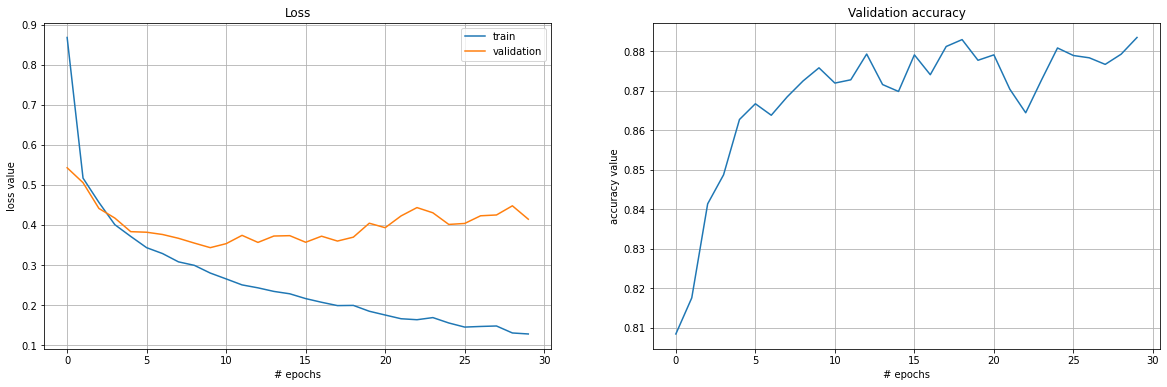

In [179]:
plot_train_process(train_loss_overfit, val_loss_overfir, val_accuracy_overfit)

In [180]:
accuracy_test(model_overfit, test_loader_overfit)

Accuracy on test set: 0.875


### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [181]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()

        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape),
            nn.ReLU(),
            nn.Linear(input_shape, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ELU(),
            nn.Linear(500, 500),
            nn.BatchNorm1d(500),
            nn.ELU(),
            nn.Linear(500, 324),
            nn.ReLU(),
            nn.Linear(324, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(100, num_classes)
        )
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [182]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 784]         615,440
              ReLU-3                  [-1, 784]               0
            Linear-4                  [-1, 500]         392,500
       BatchNorm1d-5                  [-1, 500]           1,000
              ReLU-6                  [-1, 500]               0
            Linear-7                  [-1, 500]         250,500
               ELU-8                  [-1, 500]               0
            Linear-9                  [-1, 500]         250,500
      BatchNorm1d-10                  [-1, 500]           1,000
              ELU-11                  [-1, 500]               0
           Linear-12                  [-1, 324]         162,324
             ReLU-13                  [-1, 324]               0
           Linear-14                  [

In [183]:
fixed_model = FixedNeuralNetwork().to(device)

loss_func = nn.CrossEntropyLoss()
optim = torch.optim.Adam(fixed_model.parameters(), lr = 3e-4)  

# Your experiments, come here

train_loss_fixed, val_loss_fixed, val_accuracy_fixed = train_model(fixed_model, train_loader, val_loader, loss_fn = loss_func, optimizer = optim, n_epochs = 30)

Epoch #1 / 30
train loss: 0.61855
validation loss: 0.43484
validation accuracy: 0.84519 

Epoch #2 / 30
train loss: 0.40805
validation loss: 0.3494
validation accuracy: 0.87141 

Epoch #3 / 30
train loss: 0.36125
validation loss: 0.28708
validation accuracy: 0.89463 

Epoch #4 / 30
train loss: 0.33052
validation loss: 0.27761
validation accuracy: 0.89528 

Epoch #5 / 30
train loss: 0.30328
validation loss: 0.2855
validation accuracy: 0.89456 

Epoch #6 / 30
train loss: 0.28859
validation loss: 0.24637
validation accuracy: 0.90759 

Epoch #7 / 30
train loss: 0.26946
validation loss: 0.23205
validation accuracy: 0.91327 

Epoch #8 / 30
train loss: 0.25662
validation loss: 0.2218
validation accuracy: 0.91717 

Epoch #9 / 30
train loss: 0.24316
validation loss: 0.21762
validation accuracy: 0.91748 

Epoch #10 / 30
train loss: 0.23715
validation loss: 0.22297
validation accuracy: 0.9135 

Epoch #11 / 30
train loss: 0.2225
validation loss: 0.22359
validation accuracy: 0.91813 

Epoch #12 / 3

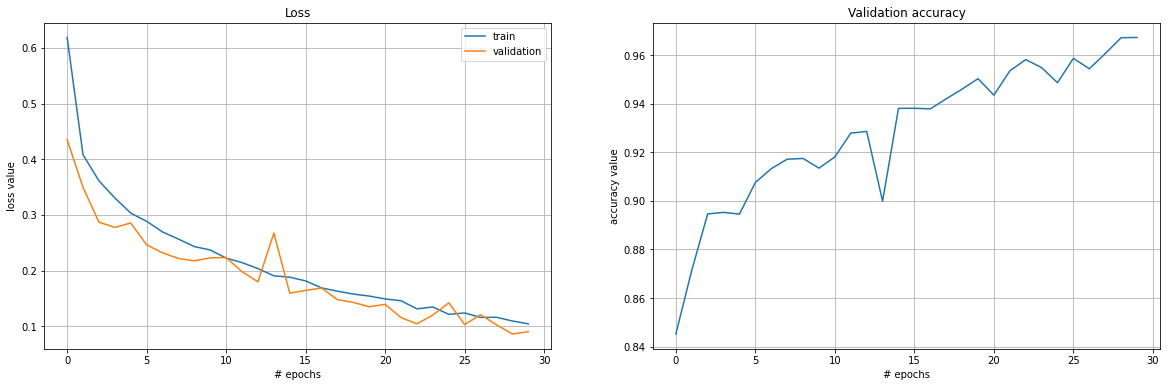

In [184]:
plot_train_process(train_loss_fixed, val_loss_fixed, val_accuracy_fixed)

In [185]:
accuracy_test(fixed_model, test_loader)

Accuracy on test set: 0.8921


### Conclusions:
_Write down small report with your conclusions and your ideas._

* In fact, it was not very easy for me to overfit the model. <br>
Having put, as it seemed to me, many layers for this task, it still gave out good accuracy. Any significant overfitting was achieved by reducing the size of the training sample from 80% to 50% of the original test dataset

* As expected, after using Batchnorm and Dropout retraining has been reduced